Load Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import re
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from konlpy.tag import Mecab
mecab = Mecab()
from wordcloud import WordCloud
from collections import Counter

Load Data

In [97]:
train = pd.read_csv("/Users/smile/Desktop/비어플/영화리뷰/dataset/train.csv")

In [98]:
test = pd.read_csv("/Users/smile/Desktop/비어플/영화리뷰/dataset/test.csv")

In [99]:
submission = pd.read_csv("/Users/smile/Desktop/비어플/영화리뷰/dataset/sample_submission.csv")

In [100]:
test['label']=submission['label']

EDA

In [6]:
train.shape, test.shape, submission.shape

((5000, 3), (5000, 3), (5000, 2))

In [7]:
print("훈련용 리뷰 개수 :",len(train))

훈련용 리뷰 개수 : 5000


In [8]:
train.head()

,id,document,label
0,1,영상이나 음악이 이쁘다 해도 미화시킨 불륜일뿐,0
1,2,히치콕이 이 영화를 봤다면 분명 박수를 쳤을듯...,1
2,3,괜찮은 음악영화가 또 나왔군요!!! 따뜻한 겨울이 될 것 같아요~,1
3,4,아무래도 20년도지난작품이라 지금보기는너무유치하다,0
4,5,지금까지의 영화들이 그랬듯. 이 영화역시 일본에 대한 미화는 여전하다.,0


In [9]:
print(train.isnull().values.any()) # null값 없음

False


In [10]:
print("테스트용 리뷰 개수 :",len(test))

테스트용 리뷰 개수 : 5000


In [11]:
test.head()

,id,document,label
0,1,시간 때우기 좋은 영화 지루함,0
1,2,훈훈한 정이 느껴지는 영화! 가족끼리 드라마 보듯이 보면 딱~!,0
2,3,Childhood fantasy,0
3,4,멋있는 영화입니다. 잊을 수 없는!,0
4,5,너무 감동적이네요 펑펑 울었습니다,0


In [12]:
print(test.isnull().values.any()) # null값 없음

False


In [13]:
train['document'].nunique(), train['label'].nunique() # 중복 확인

(5000, 2)

In [14]:
test['document'].nunique(), train['label'].nunique() # 중복 존재 -> 중복제거x

(4999, 2)

<Axes: xlabel='label'>

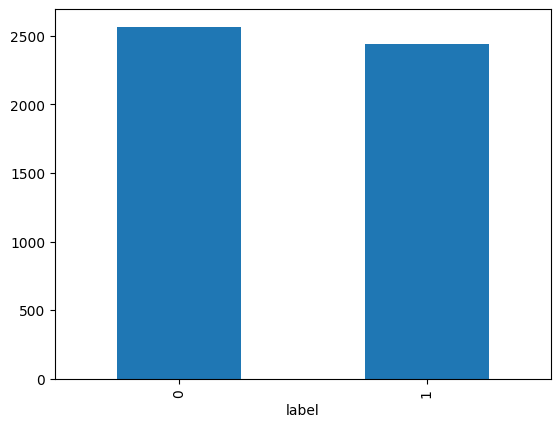

In [15]:
train['label'].value_counts().plot(kind='bar') # 긍정/부정 비율

In [16]:
print(train.groupby('label').size().reset_index(name='count')) # 0과1 리뷰 비율

   label  count
0      0   2564
1      1   2436


Processing Data

In [101]:
# 한글과 공백 제외, 모두 제거
train['document'] = train['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","",regex=True)
train.head()

,id,document,label
0,1,영상이나 음악이 이쁘다 해도 미화시킨 불륜일뿐,0
1,2,히치콕이 이 영화를 봤다면 분명 박수를 쳤을듯,1
2,3,괜찮은 음악영화가 또 나왔군요 따뜻한 겨울이 될 것 같아요,1
3,4,아무래도 년도지난작품이라 지금보기는너무유치하다,0
4,5,지금까지의 영화들이 그랬듯 이 영화역시 일본에 대한 미화는 여전하다,0


In [102]:
# 공백 데이터를 빈값으로, 빈값을 null값으로
train['document'] = train['document'].str.replace('^ +',"",regex=True)
train['document'].replace('',np.nan, inplace=True)
print(train.isnull().sum()) # null값 출력

id           0
document    10
label        0
dtype: int64


In [8]:
train.loc[train.document.isnull()] # null값 모두 긍정, 특정 패턴을 보이지않음 -> 제거

,id,document,label
159,160,NaN,1
659,660,NaN,1
721,722,NaN,1
1921,1922,NaN,1
2466,2467,NaN,1
2717,2718,NaN,1
3693,3694,NaN,1
4126,4127,NaN,1
4147,4148,NaN,1
4765,4766,NaN,1


In [20]:
# null값 확인 -> 영어로만 구성된 리뷰 데이터
train2 =pd.read_csv("/Users/smile/Desktop/비어플/영화리뷰/dataset/train.csv")
train2.iloc[[159,659,721,1921,2466,2717,3693,4126,4147,4765]]

,id,document,label
159,160,very very very good,1
659,660,revenge is sweet !!!,1
721,722,It gets better and better as it goes on :D,1
1921,1922,"Underworld: Awakening, 2012",1
2466,2467,divorce. D.I.V.O.R.C.E,1
2717,2718,"Miranda Cosgrove, A BEST",1
3693,3694,"It's a strange film, isn't it?",1
4126,4127,produced be Christopher Nolan,1
4147,4148,Thuth is out there,1
4765,4766,No comparison superb,1


In [103]:
train = train.dropna(how='any') # null값 제거

In [8]:
train.isnull().sum()

id          0
document    0
label       0
dtype: int64

In [23]:
train.shape

(4990, 3)

작업 전 WordCloud

In [104]:
text_data1 = train[train['label']==1]['document'].str.cat(sep=' ')
text_data2 = train[train['label']==0]['document'].str.cat(sep=' ')

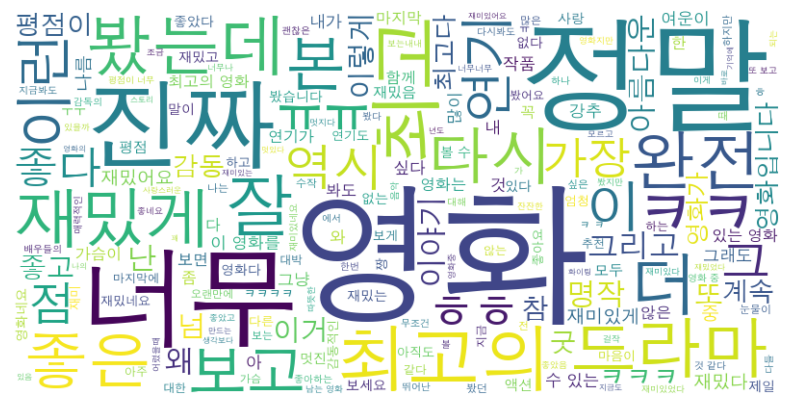

In [105]:
# 긍정 리뷰
wordcloud = WordCloud(width=800, height=400, background_color='white',font_path ="AppleGothic").generate(text_data1)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

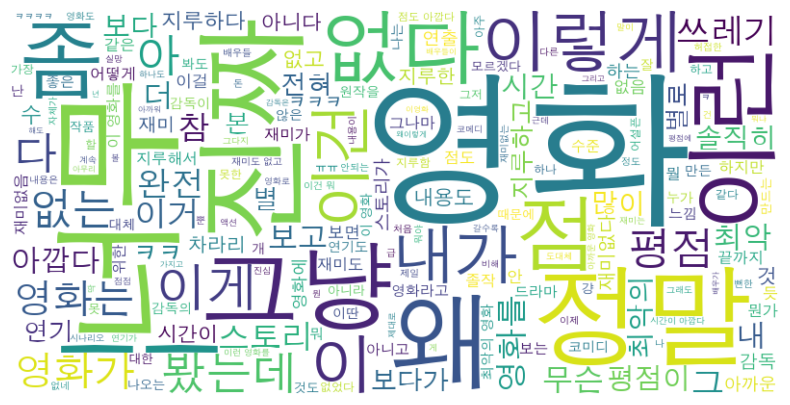

In [106]:
# 부정 리뷰
wordcloud = WordCloud(width=800, height=400, background_color='white',font_path ="AppleGothic").generate(text_data2)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [107]:
# train split
from sklearn.model_selection import train_test_split

X, y = train[['id','document']], train['label']
Xtrain, Xvalid, ytrain, yvalid = train_test_split(X, y, test_size=0.2, random_state=42)

In [108]:
Xtrain.shape, Xvalid.shape

((3992, 2), (998, 2))

In [109]:
Xtrain

,id,document
1454,1455,이게 영화인지 쓰레기인지 암튼 재미없다
3767,3768,이렇게 지루한 공포영화는 처음인게 호러
4413,4414,감독의 과한 욕심이 초래한 참극 똥을 잘 빚어서 예쁘게 데코한 느낌
882,883,곽경택 감독님 지휘 하에 연기하고 싶은 날입니다정말 대단하신 분이다
2566,2567,정말 감동적으로 본 영화에요
...,...,...
4435,4436,이게 대체 왜 점대인지 이해할 수 없음
467,468,견자단과 성룡의 대결씬과 이쁜 여자들만 볼만 나머진 기대 하지 말것
3098,3099,재미도 없고내용도 뻔하고핵심이 되어야 할 긴장감도 없다
3779,3780,정말 심하다 각본도 뒤죽박죽 그들은 알지만 우리는 모르는 일만


In [110]:
Xvalid

,id,document
4736,4737,한국 드라마중 최고의 시청률 시청률을 봐도 알 수 있듯이 그당시 최고였다
2320,2321,홍콩명배우 모두출연함 ㅎㅎ 성룡이연걸유덕화홍금보오경 등등 굿
3675,3676,야밤에 완전 깔깔대고 웃었다 정신없고 재밌음 ㅋㅋ
1215,1216,잔인 스토리탄탄하고 작품성있고 몰입성도 좋지만 뭐랄까 안타깝달까
3038,3039,아좋다 이걸 이제 보다니
...,...,...
3533,3534,너무너무 잼나요 역시 꿀잼
4553,4554,송승헌엄정아연기잘하네요잼났습니다웃기겅
4038,4039,감히 이 영화가 반열에 오른다고 있을 수 없다 그래서 점
4916,4917,오싹한 비쥬얼에 비해 아무런 영감을 주지못하는 도식적인 플롯


Tokenization

In [111]:
# 부정 리뷰 토큰화
negative = []
for sentence in tqdm(train.query("label == 0")["document"]):
    # mecab 형태소 분석기 사용
    tokenized_sentence = mecab.morphs(sentence)
    
    all_sentence = [word for word in tokenized_sentence]
    negative.append(all_sentence)

100%|████████████████████████████████████| 2564/2564 [00:00<00:00, 24434.19it/s]


In [112]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(negative)
print(tokenizer.word_index)

{'는': 1, '다': 2, '이': 3, '영화': 4, '하': 5, '도': 6, '고': 7, '가': 8, '에': 9, '없': 10, '은': 11, '의': 12, '보': 13, '을': 14, '한': 15, '지': 16, '를': 17, '게': 18, '나': 19, '들': 20, '만': 21, '너무': 22, '네': 23, '안': 24, '점': 25, '음': 26, '로': 27, '는데': 28, '지루': 29, '재미없': 30, '진짜': 31, '있': 32, '왜': 33, '아': 34, '거': 35, '기': 36, '이런': 37, '어': 38, '평점': 39, '것': 40, '었': 41, '했': 42, '내': 43, '봤': 44, '시간': 45, '말': 46, '정말': 47, '뭐': 48, '재미': 49, '으로': 50, '좋': 51, '스토리': 52, '겠': 53, '최악': 54, '내용': 55, '냐': 56, '면': 57, '않': 58, '되': 59, '아니': 60, '같': 61, '적': 62, '지만': 63, '좀': 64, '듯': 65, '아깝': 66, '주': 67, '할': 68, '그냥': 69, 'ㅡㅡ': 70, '수': 71, '인': 72, '았': 73, '만들': 74, '연기': 75, '감독': 76, '에서': 77, 'ㅋㅋ': 78, '돈': 79, '배우': 80, '쓰레기': 81, '보다': 82, 'ㅋㅋㅋ': 83, '이게': 84, '함': 85, '못': 86, '네요': 87, '끝': 88, '이건': 89, '과': 90, '알': 91, '해': 92, '까지': 93, '이렇게': 94, '개': 95, '라': 96, '더': 97, '해서': 98, '본': 99, '별로': 100, '이거': 101, '나오': 102, '다가': 103, '볼': 104, '싶': 105, '던': 106, '서'

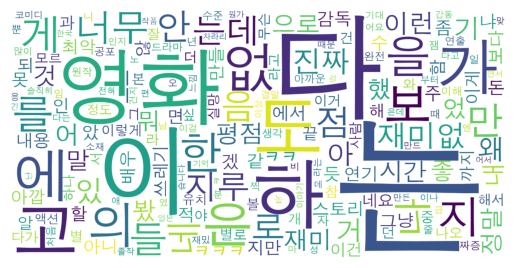

In [113]:
# negative wordcloud
from collections import Counter
c = Counter(tokenizer.word_index)

# 최대 등장 횟수를 찾습니다.
max_frequency = max(c.values())

# WordCloud 객체 생성
wc = WordCloud(font_path='AppleGothic', width=800, height=400, scale=2.0, max_font_size=250, background_color='white')

# 단어별 크기를 등장 횟수의 역수로 설정하여 WordCloud를 생성
# 등장 횟수가 많은 단어일수록 크기가 작게 표시됩니다.
wordcloud_data = {word: max_frequency / freq for word, freq in c.items()}

# WordCloud를 생성
gen = wc.generate_from_frequencies(wordcloud_data)

# WordCloud를 시각화
plt.figure()
plt.imshow(gen)
plt.axis("off")  # 축 제거 (optional)
plt.show()

In [114]:
# 부정 리뷰 토큰화
positive = []
for sentence in tqdm(train.query("label == 1")["document"]):
    # mecab 형태소 분석기 사용
    tokenized_sentence = mecab.morphs(sentence)
    
    all_sentence = [word for word in tokenized_sentence]
    positive.append(all_sentence)

100%|████████████████████████████████████| 2426/2426 [00:00<00:00, 24240.78it/s]


In [115]:
tokenizer.fit_on_texts(positive)
print(tokenizer.word_index)

{'이': 1, '영화': 2, '는': 3, '다': 4, '고': 5, '하': 6, '도': 7, '의': 8, '가': 9, '에': 10, '은': 11, '보': 12, '을': 13, '한': 14, '게': 15, '지': 16, '없': 17, '들': 18, '를': 19, '좋': 20, '너무': 21, '있': 22, '봤': 23, '정말': 24, '었': 25, '나': 26, '만': 27, '는데': 28, '재밌': 29, '음': 30, '네요': 31, '진짜': 32, '적': 33, '최고': 34, '안': 35, '로': 36, '아': 37, 'ㅋㅋ': 38, '점': 39, '지만': 40, '네': 41, '어': 42, '것': 43, '했': 44, '으로': 45, '내': 46, '기': 47, '았': 48, '수': 49, '왜': 50, '연기': 51, '않': 52, '이런': 53, '같': 54, '평점': 55, '말': 56, '되': 57, '과': 58, 'ㅋㅋㅋ': 59, '거': 60, '어요': 61, '잘': 62, '인': 63, '던': 64, '에서': 65, '지루': 66, '면': 67, '감동': 68, '재미': 69, '주': 70, '싶': 71, '할': 72, '겠': 73, '듯': 74, '재미있': 75, '재미없': 76, '본': 77, '중': 78, '드라마': 79, '배우': 80, '시간': 81, '해': 82, '와': 83, '스토리': 84, '때': 85, '뭐': 86, '습니다': 87, '잼': 88, '볼': 89, '내용': 90, '더': 91, '그': 92, '함': 93, '보다': 94, '좀': 95, '만들': 96, '아니': 97, '까지': 98, '감독': 99, '그냥': 100, '냐': 101, '생각': 102, '사랑': 103, '사람': 104, '년': 105, '최악': 106, '완전

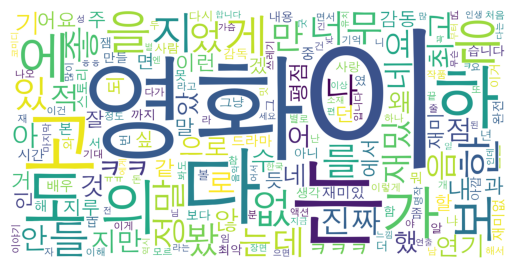

In [116]:
# positive wordcloud

c = Counter(tokenizer.word_index)

# 최대 등장 횟수를 찾습니다.
max_frequency = max(c.values())

# WordCloud 객체 생성
wc = WordCloud(font_path='AppleGothic', width=800, height=400, scale=2.0, max_font_size=250, background_color='white')

# 단어별 크기를 등장 횟수의 역수로 설정하여 WordCloud를 생성
# 등장 횟수가 많은 단어일수록 크기가 작게 표시됩니다.
wordcloud_data = {word: max_frequency / freq for word, freq in c.items()}

# WordCloud를 생성
gen = wc.generate_from_frequencies(wordcloud_data)

# WordCloud를 시각화
plt.figure()
plt.imshow(gen)
plt.axis("off")  # 축 제거 (optional)
plt.show()

In [117]:
# 최종 불용어 사전(통일)
stopwords =['영화', '이', '의', '가', '에', '도', '을', '는', '를', '은', '한', '다', '만',  '로', '과',  '으로', '것', '에서', '게', '인', '이다', '요', '까지', '하는', '고', '하고', '지',  '입니다',  '있다','하다','되다','다', '하', '고', '는데',  '었', '했', '으로', '겠', '면',  '았', '에서', '네요', '알', '해',  '습니다', '어요', '때', '과',  '하다', 'ㄹ',  '어', '아', 'ㅂ니다', '걍', '과', '도', '으로', '자', '한', '하다', '하', 'ㄴ', 'ㅁ',  '주', '적','기',  '어요', 'ㄴ다', '아서', '로', '수',  '던',  '그',  '시', '냐', '어서', '아도', '라', 'ㄴ데', '스럽', 'ㄴ가']

In [118]:
print(stopwords)

['영화', '이', '의', '가', '에', '도', '을', '는', '를', '은', '한', '다', '만', '로', '과', '으로', '것', '에서', '게', '인', '이다', '요', '까지', '하는', '고', '하고', '지', '입니다', '있다', '하다', '되다', '다', '하', '고', '는데', '었', '했', '으로', '겠', '면', '았', '에서', '네요', '알', '해', '습니다', '어요', '때', '과', '하다', 'ㄹ', '어', '아', 'ㅂ니다', '걍', '과', '도', '으로', '자', '한', '하다', '하', 'ㄴ', 'ㅁ', '주', '적', '기', '어요', 'ㄴ다', '아서', '로', '수', '던', '그', '시', '냐', '어서', '아도', '라', 'ㄴ데', '스럽', 'ㄴ가']


In [119]:
X_train = []
for sentence in tqdm(Xtrain['document']):
    tokenized_sentence = mecab.morphs(sentence) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords]
    X_train.append(stopwords_removed_sentence)

100%|████████████████████████████████████| 3992/3992 [00:00<00:00, 21562.07it/s]


In [12]:
X_train[:5]

[['이게', '인지', '쓰레기', '인지', '암튼', '재미없'],
 ['이렇게', '지루', '공포', '처음', '호러'],
 ['감독', '욕심', '초래', '참극', '똥', '잘', '빚', '예쁘', '데', '코', '느낌'],
 ['곽경택', '감독', '님', '지휘', '연기', '싶', '날', '정말', '대단', '신', '분'],
 ['정말', '감동', '본']]

In [120]:
X_valid = []
for sentence in tqdm(Xvalid['document']):
    tokenized_sentence = mecab.morphs(sentence) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords]
    X_valid.append(stopwords_removed_sentence)

100%|██████████████████████████████████████| 998/998 [00:00<00:00, 17640.95it/s]


In [14]:
X_valid[:5]

[['한국',
  '드라마',
  '중',
  '최고',
  '시청',
  '률',
  '시청',
  '률',
  '봐도',
  '있',
  '듯이',
  '당시',
  '최고',
  '였'],
 ['홍콩',
  '명배우',
  '모두',
  '출연',
  '함',
  'ㅎㅎ',
  '성룡',
  '이연걸',
  '유덕화',
  '홍금보',
  '오경',
  '등등',
  '굿'],
 ['야밤', '완전', '깔깔대', '웃', '정신없', '재밌', '음', 'ㅋㅋ'],
 ['잔인',
  '스토리',
  '탄탄',
  '작품',
  '성',
  '있',
  '몰입',
  '성',
  '좋',
  '지만',
  '뭐',
  '랄까',
  '안타깝',
  '달까'],
 ['좋', '이걸', '이제', '보', '다니']]

Interger Encoding

In [121]:
# 정수인코딩
mecab_tokenizer = Tokenizer()
mecab_tokenizer.fit_on_texts(X_train) # 빈도수를 기준으로 단어 집합 생성

In [122]:
print(mecab_tokenizer.word_index) # 빈도수가 높은 순으로 낮은 정수 인덱스 부여 -> 불용어 사전 추가

{'보': 1, '없': 2, '들': 3, '좋': 4, '있': 5, '너무': 6, '정말': 7, '봤': 8, '나': 9, '음': 10, '재밌': 11, '진짜': 12, '최고': 13, '안': 14, 'ㅋㅋ': 15, '지만': 16, '네': 17, '점': 18, '연기': 19, '않': 20, '왜': 21, 'ㅋㅋㅋ': 22, '되': 23, '이런': 24, '내': 25, '평점': 26, '같': 27, '말': 28, '거': 29, '잘': 30, '감동': 31, '지루': 32, '할': 33, '싶': 34, '재미없': 35, '재미': 36, '재미있': 37, '듯': 38, '본': 39, '와': 40, '배우': 41, '스토리': 42, '드라마': 43, '중': 44, '내용': 45, '만들': 46, '볼': 47, '아니': 48, '시간': 49, '잼': 50, '더': 51, '함': 52, '뭐': 53, '보다': 54, '그냥': 55, '감독': 56, '좀': 57, '사람': 58, '최악': 59, '번': 60, '생각': 61, '사랑': 62, '서': 63, '였': 64, '이렇게': 65, '완전': 66, 'ㅡㅡ': 67, '다시': 68, '못': 69, '아깝': 70, '액션': 71, '해서': 72, '년': 73, '이거': 74, '기대': 75, '남': 76, '끝': 77, '돈': 78, '작품': 79, 'ㅠㅠ': 80, '굿': 81, '이야기': 82, '참': 83, '이건': 84, '나오': 85, '쓰레기': 86, '이게': 87, '면서': 88, '별로': 89, '모르': 90, '개': 91, '니': 92, '하나': 93, '봐도': 94, '다가': 95, '마지막': 96, '기억': 97, '넘': 98, '건': 99, '두': 100, '재': 101, '이해': 102, '임': 103, '야': 104, '또'

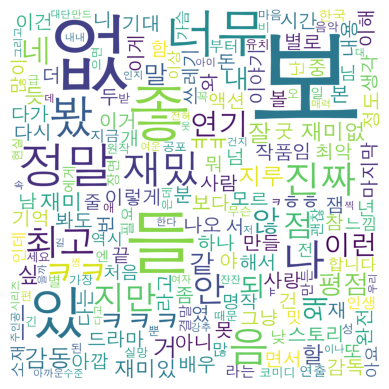

In [123]:
# 불용어 제거 후 word cloud
c = Counter(mecab_tokenizer.word_index)
# 최대 등장 횟수를 찾습니다.
max_frequency = max(c.values())
# WordCloud 객체 생성
wc = WordCloud(font_path='AppleGothic', width=800, height=800, scale=2.0, max_font_size=250, background_color='white')

# 단어별 크기를 등장 횟수의 역수로 설정하여 WordCloud를 생성
# 등장 횟수가 많은 단어일수록 크기가 작게 표시됩니다.
wordcloud_data = {word: max_frequency / freq for word, freq in c.items()}

# WordCloud를 생성
gen = wc.generate_from_frequencies(wordcloud_data)

# WordCloud를 시각화
plt.figure()
plt.imshow(gen)
plt.axis("off")  # 축 제거 (optional)
plt.show()

In [17]:
threshold = 3 # 빈도수 설정
total_cnt = len(mecab_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in mecab_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 6222
등장 빈도가 2번 이하인 희귀 단어의 수: 4507
단어 집합에서 희귀 단어의 비율: 72.4365155898425
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 16.833473638262713


In [18]:
# 등장 빈도 2번 이하 단어 제거
vocab_size = total_cnt - rare_cnt +1
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 1716


In [19]:
mecab_tokenizer = Tokenizer(vocab_size) # 빈도수 상위 1762개 단어 사용
mecab_tokenizer.fit_on_texts(X_train)
X_train = mecab_tokenizer.texts_to_sequences(X_train)
X_valid = mecab_tokenizer.texts_to_sequences(X_valid)

In [20]:
X_train[:5]

[[87, 189, 86, 189, 35],
 [65, 32, 152, 114, 1066],
 [56, 879, 30, 496, 190, 605, 123],
 [56, 115, 19, 34, 454, 7, 181, 273, 106],
 [7, 31, 39]]

In [21]:
X_valid[:5]

[[141, 43, 44, 13, 841, 842, 841, 842, 94, 5, 1298, 263, 13, 64],
 [1083, 1270, 242, 412, 52, 107, 656, 1259, 81],
 [66, 194, 11, 10, 15],
 [601, 42, 1665, 79, 147, 5, 352, 147, 4, 16, 53, 1674],
 [4, 210, 288, 1, 233]]

Remove empty samples

In [22]:
len(X_train), len(ytrain)

(3992, 3992)

In [23]:
len(X_valid), len(yvalid)

(998, 998)

In [24]:
# 단어집합 축소로 인해 생긴 empty value 제거
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]

In [25]:
print(drop_train)

[303, 965, 3037, 3751]


In [26]:
X_train = [X_train[i] for i in range(len(X_train)) if i not in drop_train]

In [27]:
ytrain = np.delete(ytrain,drop_train)

In [28]:
len(X_train), len(ytrain)

(3988, 3988)

In [29]:
# valid set: 단어집합 축소로 인해 생긴 empty value 제거
drop_train_v = [index for index, sentence in enumerate(X_valid) if len(sentence) < 1]

In [30]:
print(drop_train_v)

[79]


In [31]:
X_valid = [X_valid[i] for i in range(len(X_valid)) if i not in drop_train_v]

In [32]:
yvalid = np.delete(yvalid,drop_train_v)

In [33]:
len(X_valid), len(yvalid)

(997, 997)

padding

리뷰의 최대 길이 : 26
리뷰의 평균 길이 : 6.688565697091274


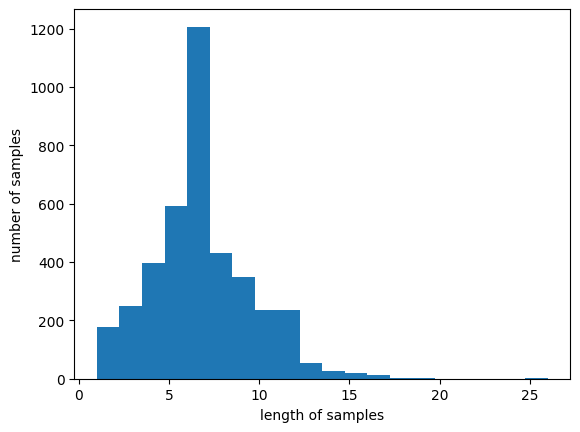

In [34]:
# 패딩
print('리뷰의 최대 길이 :',max(len(review) for review in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(review) for review in X_train], bins=20)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [35]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

In [36]:
max_len = 15
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 15 이하인 샘플의 비율: 99.62387161484455


In [37]:
# 15으로 패딩
X_train = pad_sequences(X_train, maxlen=max_len)
X_valid = pad_sequences(X_valid, maxlen=max_len)

In [38]:
print(X_train)

[[   0    0    0 ...   86  189   35]
 [   0    0    0 ...  152  114 1066]
 [   0    0    0 ...  190  605  123]
 ...
 [   0    0    0 ...   33  283    2]
 [   0    0    0 ...  197   90  138]
 [   0    0    0 ...  205  159  297]]


In [39]:
print(X_valid)

[[   0  141   43 ...  263   13   64]
 [   0    0    0 ...  656 1259   81]
 [   0    0    0 ...   11   10   15]
 ...
 [   0    0    0 ...    2  461   18]
 [   0    0    0 ... 1209  268 1699]
 [   0    0    0 ...   54   30  176]]


In [40]:
ytrain

array([0, 0, 0, ..., 0, 0, 0])

In [41]:
yvalid

array([1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0,
       1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1,
       1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1,
       0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0,
       1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1,
       1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,

Classification Modeling

LSTM

In [44]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dropout

embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(LSTM(hidden_units, kernel_regularizer=regularizers.l2(0.009))) # l2 규제, 복잡성 감소
model.add(Dropout(0.35))
model.add(Dense(1, activation='sigmoid')) # 이진분류

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True) # 최고 성능 모델 저장 용도, 나중에 쓸일 있으면 

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, ytrain, epochs=5, callbacks=[es, mc], batch_size=64, validation_split=0.2)

Epoch 1/5
47/50 [===========================>..] - ETA: 0s - loss: 1.2775 - acc: 0.6220
Epoch 1: val_acc improved from -inf to 0.68546, saving model to best_model.h5
50/50 [==============================] - 2s 19ms/step - loss: 1.2477 - acc: 0.6288 - val_loss: 0.7565 - val_acc: 0.6855
Epoch 2/5
13/50 [======>.......................] - ETA: 0s - loss: 0.6363 - acc: 0.8101

/Users/smile/anaconda3/envs/mecab/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


49/50 [============================>.] - ETA: 0s - loss: 0.5187 - acc: 0.8396
Epoch 2: val_acc improved from 0.68546 to 0.81830, saving model to best_model.h5
50/50 [==============================] - 1s 15ms/step - loss: 0.5185 - acc: 0.8382 - val_loss: 0.4613 - val_acc: 0.8183
Epoch 3/5
49/50 [============================>.] - ETA: 0s - loss: 0.3577 - acc: 0.8795
Epoch 3: val_acc improved from 0.81830 to 0.82957, saving model to best_model.h5
50/50 [==============================] - 1s 16ms/step - loss: 0.3580 - acc: 0.8787 - val_loss: 0.4137 - val_acc: 0.8296
Epoch 4/5
47/50 [===========================>..] - ETA: 0s - loss: 0.3041 - acc: 0.8933
Epoch 4: val_acc improved from 0.82957 to 0.83459, saving model to best_model.h5
50/50 [==============================] - 1s 18ms/step - loss: 0.3032 - acc: 0.8931 - val_loss: 0.3978 - val_acc: 0.8346
Epoch 5/5
49/50 [============================>.] - ETA: 0s - loss: 0.2630 - acc: 0.9139
Epoch 5: val_acc did not improve from 0.83459
50/50 [==

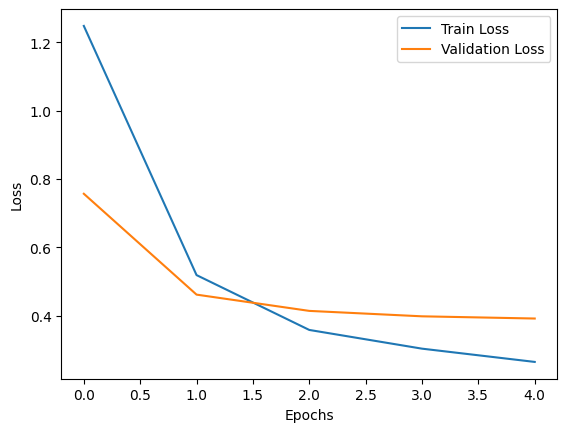

In [45]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [46]:
# valid set 모델 검증
accuracy = model.evaluate(X_valid, yvalid)
print(f"Validation 세트 정확도: {accuracy}")

32/32 [==============================] - 0s 3ms/step - loss: 0.4031 - acc: 0.8415
Validation 세트 정확도: [0.40307408571243286, 0.841524600982666]


In [142]:
sentiment_predict('스토리가 왜이래')

1/1 [==============================] - 0s 13ms/step
86.48% 확률로 부정 리뷰입니다.



RNN

In [63]:
from tensorflow.keras.layers import SimpleRNN, Embedding, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer

embedding_dim = 32
hidden_units = 32

model_Rnn = Sequential()
model_Rnn.add(Embedding(vocab_size, embedding_dim))
model_Rnn.add(SimpleRNN(hidden_units))
model_Rnn.add(Dropout(0.5))
model_Rnn.add(Dense(1, activation='sigmoid'))

model_Rnn.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history_rnn = model_Rnn.fit(X_train, ytrain, epochs=7, batch_size=20, validation_split=0.2)

Epoch 1/7
160/160 [==============================] - 1s 2ms/step - loss: 0.6763 - acc: 0.5815 - val_loss: 0.5999 - val_acc: 0.7632
Epoch 2/7
160/160 [==============================] - 0s 2ms/step - loss: 0.4578 - acc: 0.8141 - val_loss: 0.4217 - val_acc: 0.8208
Epoch 3/7
160/160 [==============================] - 0s 2ms/step - loss: 0.3035 - acc: 0.8796 - val_loss: 0.4363 - val_acc: 0.8095
Epoch 4/7
160/160 [==============================] - 0s 2ms/step - loss: 0.2259 - acc: 0.9135 - val_loss: 0.3631 - val_acc: 0.8283
Epoch 5/7
160/160 [==============================] - 0s 2ms/step - loss: 0.1834 - acc: 0.9326 - val_loss: 0.3813 - val_acc: 0.8308
Epoch 6/7
160/160 [==============================] - 0s 2ms/step - loss: 0.1300 - acc: 0.9524 - val_loss: 0.4274 - val_acc: 0.8221
Epoch 7/7
160/160 [==============================] - 0s 2ms/step - loss: 0.0940 - acc: 0.9665 - val_loss: 0.4981 - val_acc: 0.8158


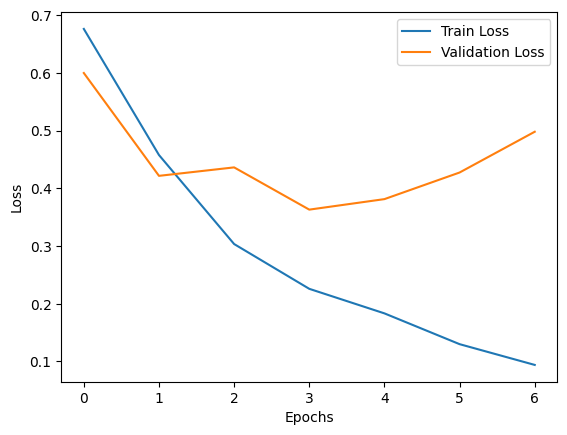

In [64]:
plt.plot(history_rnn.history['loss'], label='Train Loss')
plt.plot(history_rnn.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [65]:
accuracy = model_Rnn.evaluate(X_valid, yvalid)
print(f"Validation 세트 정확도: {accuracy}")

32/32 [==============================] - 0s 689us/step - loss: 0.4901 - acc: 0.8205
Validation 세트 정확도: [0.49006834626197815, 0.8204613924026489]


랜덤포레스트

In [87]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# 랜덤포레스트 모델 생성
rf_model = RandomForestClassifier()

# 하이퍼파라미터 그리드 정의
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

# 그리드 서치를 통한 최적 하이퍼파라미터 탐색
grid_search = GridSearchCV(rf_model, param_grid, cv=5)
grid_search.fit(X_train, ytrain) 

# 최적 하이퍼파라미터 출력
print("최적 하이퍼파라미터:", grid_search.best_params_)


최적 하이퍼파라미터: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 300}


In [88]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

rf_model = RandomForestClassifier(n_estimators=300, max_depth=10, min_samples_split=10)
rf_model.fit(X_train, ytrain)

rf_predictions = rf_model.predict(X_valid)
accuracy = accuracy_score(yvalid, rf_predictions)
print("Random Forest Accuracy:", accuracy)


Random Forest Accuracy: 0.6108324974924775


XGB

In [73]:
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# 랜덤포레스트 모델 생성
xgb_model = xgb.XGBClassifier()

# 하이퍼파라미터 그리드 정의
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    # 다른 하이퍼파라미터도 추가 가능
}

# 그리드 서치를 통한 최적 하이퍼파라미터 탐색
grid_search = GridSearchCV(xgb_model, param_grid, cv=5)
grid_search.fit(X_train, ytrain) 

# 최적 하이퍼파라미터 출력
print("최적 하이퍼파라미터:", grid_search.best_params_)

최적 하이퍼파라미터: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 300}


In [74]:
from sklearn.metrics import accuracy_score
xgb_model = xgb.XGBClassifier(n_estimators=300, max_depth=3,learning_rate=0.2)
xgb_model.fit(X_train, ytrain)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [75]:
xgb_predictions = xgb_model.predict(X_valid)
xgb_accuracy = accuracy_score(yvalid, xgb_predictions)

print(f"XGBoost Accuracy: {xgb_accuracy}")

XGBoost Accuracy: 0.6720160481444333


최종 Test

In [47]:
test['document'] = test['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","",regex=True)
test['document'] = test['document'].str.replace('^ +',"",regex=True)
#test['document'].replace('',np.nan, inplace=True) # 한글과 공백을 제외하고 모두 제거
test.isnull().sum() # 공백은 Null 값으로 변경

id          0
document    0
label       0
dtype: int64

In [48]:
test.loc[test.document.isnull()].index

Index([], dtype='int64')

In [ ]:
# test 영어리뷰 -> 모두 긍정으로 처리

In [162]:
test2 = pd.read_csv("/Users/smile/Desktop/비어플/영화리뷰/dataset/test.csv")  # 영어로된 리뷰 모두 긍정
test2.iloc[[   2,  458,  662,  756, 1023, 1313, 1325, 1386, 1392, 2294, 2599, 3060, 3473, 3654, 3857, 3997, 4001, 4707]]

,id,document
2,3,Childhood fantasy
458,459,"""Amazing discovery!"""
662,663,LIFE + DOG = GREAT
756,757,It was very good!!!
1023,1024,You saw what you wanted to see.
1313,1314,thank you! very good job ^^
1325,1326,It was a nice super duper!!!!
1386,1387,Best animation ever
1392,1393,Brilliant! This is a must-see film
2294,2295,What a great drama!!!


In [49]:
# test 전처리 동일 진행 -> 제거된 데이터 처리 어떻게 할건지 생각.
#test.drop_duplicates(subset = ['document'], inplace=True) # document 열에서 중복인 내용이 있다면 중복 제거 -> 데이콘 제출시 중복제거x
#test = test.dropna(how='any') # Null 값 18개 제거 -> 데이콘 제출시 null 값 제거x
print('전처리 후 테스트용 샘플의 개수 :',len(test))

전처리 후 테스트용 샘플의 개수 : 5000


In [50]:
X_test = []
excluded_indices =[2,458,662,756,1023,1313,1325,1386,1392,2294,2599,3060,3473,3654,3857,3997,4001,4707]
for sentence in tqdm(test['document']):
    tokenized_sentence = mecab.morphs(sentence)
    stopwords_removed_sentence = [tokenized_sentence[i] for i in range(len(tokenized_sentence)) if i not in excluded_indices]
    X_test.append(stopwords_removed_sentence)

100%|████████████████████████████████████| 5000/5000 [00:00<00:00, 21014.49it/s]


In [51]:
#mecab_tokenizer = Tokenizer(vocab_size) # 빈도수 상위 1647개 단어 사용, 등장빈도가 2번 이하인 희귀 단어의 수: 4506개
#mecab_tokenizer.fit_on_texts(X_test)
X_test = mecab_tokenizer.texts_to_sequences(X_test)

In [52]:
# 단어집합 축소로 인해 생긴 empty value는 처리?
drop_test = [index for index, sentence in enumerate(X_test) if len(sentence) < 1]

In [53]:
print(drop_test)

[2, 12, 417, 458, 636, 662, 673, 756, 826, 896, 944, 1023, 1144, 1164, 1313, 1325, 1386, 1392, 1420, 1534, 1595, 1614, 1803, 2201, 2294, 2383, 2597, 2599, 2694, 2841, 2862, 2903, 3051, 3060, 3416, 3436, 3473, 3507, 3654, 3754, 3857, 3997, 4001, 4045, 4110, 4423, 4583, 4625, 4678, 4707]


In [54]:
X_test = pad_sequences(X_test, maxlen=max_len)

In [89]:
predicted_probabilities = rf_model.predict(X_test)  # X_test는 테스트 데이터
predicted_classes = (predicted_probabilities > 0.5).astype('int32')  # 확률을 클래스로 변환 (임계값은 조정 가능)

# 예측한 결과 출력
for i in range(len(X_test)):
    print(f"Review: {X_test[i]}")
    print(f"Predicted Probability: {predicted_probabilities[i]}")
    print(f"Predicted Class: {predicted_classes[i]}")
    print()

Review: [   0    0    0    0    0    0    0    0    0    0    0   49 1262    4
  380]
Predicted Probability: 1
Predicted Class: 1

Review: [   0    0    0    0    0    0    0  568  459  474   43    1 1298    1
  332]
Predicted Probability: 0
Predicted Class: 0

Review: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Predicted Probability: 0
Predicted Class: 0

Review: [  0   0   0   0   0   0   0   0   0   0   0   0 264 599   2]
Predicted Probability: 0
Predicted Class: 0

Review: [  0   0   0   0   0   0   0   0   0   0   0   0   6  31 247]
Predicted Probability: 1
Predicted Class: 1

Review: [  0   0   0   0   0   0   0   0   0   0  57 517  21 323  29]
Predicted Probability: 0
Predicted Class: 0

Review: [  0   0   0   0   0 483 604 169  39  16  25  76   3 604 217]
Predicted Probability: 1
Predicted Class: 1

Review: [   0    0    0    0    0    0    0    0    0    0  341   45  985 1385
   20]
Predicted Probability: 0
Predicted Class: 0

Review: [  0   0   0   0   0   0   0   0   0 801 190  68  14 1

In [90]:
test['label'] = predicted_classes

In [91]:
excluded_index = [2,  458,  662,  756, 1023, 1313, 1325, 1386, 1392, 2294, 2599, 3060, 3473, 3654, 3857, 3997, 4001, 4707]
for index in excluded_index:
    test.loc[index, 'label'] = 1

In [92]:
test.head()

,id,document,label
0,1,시간 때우기 좋은 영화 지루함,1
1,2,훈훈한 정이 느껴지는 영화 가족끼리 드라마 보듯이 보면 딱,0
2,3,,1
3,4,멋있는 영화입니다 잊을 수 없는,0
4,5,너무 감동적이네요 펑펑 울었습니다,1


In [93]:
submission['label'] = test['label']

In [94]:
print(submission)

        id  label
0        1      1
1        2      0
2        3      1
3        4      0
4        5      1
...    ...    ...
4995  4996      0
4996  4997      0
4997  4998      0
4998  4999      1
4999  5000      0

[5000 rows x 2 columns]


In [95]:
submission.to_csv('/Users/smile/Desktop/비어플/영화리뷰/test_RF.csv', index=False)

In [ ]:
# Final Test Accuracy

In [ ]:
#lstm 0.8213

In [ ]:
#rnn 0.811

In [ ]:
#random 0.62

In [ ]:
#xgboost 0.67